<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:09:00] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


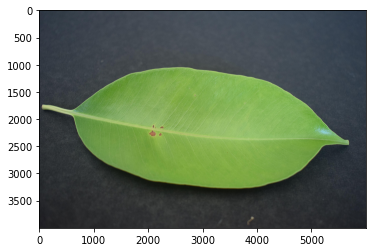

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

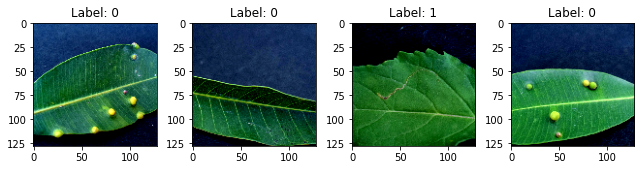

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:09:06] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:09:08] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2639187667108107 samples/sec                   batch loss = 2.2284135818481445 | accuracy = 0.2


Epoch[1] Batch[10] Speed: 1.2707757456972406 samples/sec                   batch loss = 0.6165531873703003 | accuracy = 0.375


Epoch[1] Batch[15] Speed: 1.2716653682612722 samples/sec                   batch loss = 0.6853299736976624 | accuracy = 0.4166666666666667


Epoch[1] Batch[20] Speed: 1.2686327132889172 samples/sec                   batch loss = 0.6088709831237793 | accuracy = 0.475


Epoch[1] Batch[25] Speed: 1.26096175938616 samples/sec                   batch loss = 0.8865615129470825 | accuracy = 0.5


Epoch[1] Batch[30] Speed: 1.2623117259627779 samples/sec                   batch loss = 0.4621789753437042 | accuracy = 0.525


Epoch[1] Batch[35] Speed: 1.2654487680494027 samples/sec                   batch loss = 0.46801668405532837 | accuracy = 0.5571428571428572


Epoch[1] Batch[40] Speed: 1.257435672204524 samples/sec                   batch loss = 1.0745303630828857 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.2627238658587103 samples/sec                   batch loss = 0.6875348091125488 | accuracy = 0.5777777777777777


Epoch[1] Batch[50] Speed: 1.2641250422606547 samples/sec                   batch loss = 0.5496950149536133 | accuracy = 0.565


Epoch[1] Batch[55] Speed: 1.2618805877849395 samples/sec                   batch loss = 0.9966610074043274 | accuracy = 0.5409090909090909


Epoch[1] Batch[60] Speed: 1.268595301909999 samples/sec                   batch loss = 0.7646850347518921 | accuracy = 0.5458333333333333


Epoch[1] Batch[65] Speed: 1.2625057915211904 samples/sec                   batch loss = 0.8159302473068237 | accuracy = 0.5384615384615384


Epoch[1] Batch[70] Speed: 1.264890545063021 samples/sec                   batch loss = 0.7738773822784424 | accuracy = 0.5428571428571428


Epoch[1] Batch[75] Speed: 1.2677359277418716 samples/sec                   batch loss = 0.5597302317619324 | accuracy = 0.5466666666666666


Epoch[1] Batch[80] Speed: 1.266434373018509 samples/sec                   batch loss = 0.7352100610733032 | accuracy = 0.540625


Epoch[1] Batch[85] Speed: 1.264272790640719 samples/sec                   batch loss = 0.4809423089027405 | accuracy = 0.55


Epoch[1] Batch[90] Speed: 1.2666105832984857 samples/sec                   batch loss = 0.3638486862182617 | accuracy = 0.5583333333333333


Epoch[1] Batch[95] Speed: 1.2619366826889518 samples/sec                   batch loss = 0.79680997133255 | accuracy = 0.5684210526315789


Epoch[1] Batch[100] Speed: 1.2664786361007665 samples/sec                   batch loss = 0.2992092967033386 | accuracy = 0.565


Epoch[1] Batch[105] Speed: 1.2716228622977581 samples/sec                   batch loss = 0.6203027963638306 | accuracy = 0.5619047619047619


Epoch[1] Batch[110] Speed: 1.2645356032624704 samples/sec                   batch loss = 0.5367422103881836 | accuracy = 0.5704545454545454


Epoch[1] Batch[115] Speed: 1.2641371389924134 samples/sec                   batch loss = 0.5109837651252747 | accuracy = 0.5760869565217391


Epoch[1] Batch[120] Speed: 1.2609663084993237 samples/sec                   batch loss = 0.5822387933731079 | accuracy = 0.58125


Epoch[1] Batch[125] Speed: 1.2610121805579033 samples/sec                   batch loss = 0.648593008518219 | accuracy = 0.588


Epoch[1] Batch[130] Speed: 1.2709160029801032 samples/sec                   batch loss = 0.6271162033081055 | accuracy = 0.5942307692307692


Epoch[1] Batch[135] Speed: 1.265791330078548 samples/sec                   batch loss = 0.4269777834415436 | accuracy = 0.5981481481481481


Epoch[1] Batch[140] Speed: 1.2655749635879376 samples/sec                   batch loss = 0.5316449999809265 | accuracy = 0.6071428571428571


Epoch[1] Batch[145] Speed: 1.2636251830319851 samples/sec                   batch loss = 0.5406961441040039 | accuracy = 0.6068965517241379


Epoch[1] Batch[150] Speed: 1.270431346666393 samples/sec                   batch loss = 0.41720661520957947 | accuracy = 0.6133333333333333


Epoch[1] Batch[155] Speed: 1.2702018510017976 samples/sec                   batch loss = 0.4490213096141815 | accuracy = 0.6193548387096774


Epoch[1] Batch[160] Speed: 1.2690574391435905 samples/sec                   batch loss = 0.20995627343654633 | accuracy = 0.61875


Epoch[1] Batch[165] Speed: 1.2713740521936394 samples/sec                   batch loss = 0.47436392307281494 | accuracy = 0.6212121212121212


Epoch[1] Batch[170] Speed: 1.272297027366357 samples/sec                   batch loss = 0.5834164619445801 | accuracy = 0.6191176470588236


Epoch[1] Batch[175] Speed: 1.2729607036771224 samples/sec                   batch loss = 1.0069375038146973 | accuracy = 0.62


Epoch[1] Batch[180] Speed: 1.270947004305801 samples/sec                   batch loss = 0.25718235969543457 | accuracy = 0.6194444444444445


Epoch[1] Batch[185] Speed: 1.266048659954137 samples/sec                   batch loss = 0.5843757390975952 | accuracy = 0.6202702702702703


Epoch[1] Batch[190] Speed: 1.265341970159673 samples/sec                   batch loss = 0.4665732681751251 | accuracy = 0.6210526315789474


Epoch[1] Batch[195] Speed: 1.2654918168002982 samples/sec                   batch loss = 0.42957308888435364 | accuracy = 0.6230769230769231


Epoch[1] Batch[200] Speed: 1.2671884149789607 samples/sec                   batch loss = 0.6396694183349609 | accuracy = 0.6275


Epoch[1] Batch[205] Speed: 1.2679313773568979 samples/sec                   batch loss = 0.41158968210220337 | accuracy = 0.6280487804878049


Epoch[1] Batch[210] Speed: 1.2670409412761234 samples/sec                   batch loss = 0.37936466932296753 | accuracy = 0.6273809523809524


Epoch[1] Batch[215] Speed: 1.2668655678647833 samples/sec                   batch loss = 0.5526655912399292 | accuracy = 0.6267441860465116


Epoch[1] Batch[220] Speed: 1.266237473263465 samples/sec                   batch loss = 0.5690468549728394 | accuracy = 0.6261363636363636


Epoch[1] Batch[225] Speed: 1.2708691187552323 samples/sec                   batch loss = 0.768390417098999 | accuracy = 0.6255555555555555


Epoch[1] Batch[230] Speed: 1.266669872874852 samples/sec                   batch loss = 0.392323762178421 | accuracy = 0.6228260869565218


Epoch[1] Batch[235] Speed: 1.2722513918790956 samples/sec                   batch loss = 0.4072743058204651 | accuracy = 0.6202127659574468


Epoch[1] Batch[240] Speed: 1.266512576412898 samples/sec                   batch loss = 0.3712612986564636 | accuracy = 0.6260416666666667


Epoch[1] Batch[245] Speed: 1.269713607095108 samples/sec                   batch loss = 1.143787145614624 | accuracy = 0.6255102040816326


Epoch[1] Batch[250] Speed: 1.2663736716626781 samples/sec                   batch loss = 0.5463604927062988 | accuracy = 0.627


Epoch[1] Batch[255] Speed: 1.2390153732082345 samples/sec                   batch loss = 0.4741761386394501 | accuracy = 0.6313725490196078


Epoch[1] Batch[260] Speed: 1.2647392199651484 samples/sec                   batch loss = 0.5004027485847473 | accuracy = 0.6317307692307692


Epoch[1] Batch[265] Speed: 1.2733143999477838 samples/sec                   batch loss = 0.40192878246307373 | accuracy = 0.6311320754716981


Epoch[1] Batch[270] Speed: 1.2643152830290485 samples/sec                   batch loss = 0.8345467448234558 | accuracy = 0.6342592592592593


Epoch[1] Batch[275] Speed: 1.267094050821924 samples/sec                   batch loss = 0.986235499382019 | accuracy = 0.6345454545454545


Epoch[1] Batch[280] Speed: 1.269733018173364 samples/sec                   batch loss = 0.5758160948753357 | accuracy = 0.6375


Epoch[1] Batch[285] Speed: 1.2611895396811412 samples/sec                   batch loss = 0.5623273849487305 | accuracy = 0.637719298245614


Epoch[1] Batch[290] Speed: 1.27281651846793 samples/sec                   batch loss = 0.42744529247283936 | accuracy = 0.6387931034482759


Epoch[1] Batch[295] Speed: 1.2656301462475383 samples/sec                   batch loss = 0.5816183686256409 | accuracy = 0.6406779661016949


Epoch[1] Batch[300] Speed: 1.2636642054266587 samples/sec                   batch loss = 0.5835808515548706 | accuracy = 0.6408333333333334


Epoch[1] Batch[305] Speed: 1.26524931206678 samples/sec                   batch loss = 0.7201091647148132 | accuracy = 0.6418032786885246


Epoch[1] Batch[310] Speed: 1.265926477307068 samples/sec                   batch loss = 0.4430885314941406 | accuracy = 0.6427419354838709


Epoch[1] Batch[315] Speed: 1.2685222121980408 samples/sec                   batch loss = 0.6169482469558716 | accuracy = 0.6452380952380953


Epoch[1] Batch[320] Speed: 1.2640432287122552 samples/sec                   batch loss = 0.5143322944641113 | accuracy = 0.64921875


Epoch[1] Batch[325] Speed: 1.2625323935061956 samples/sec                   batch loss = 0.431443452835083 | accuracy = 0.6492307692307693


Epoch[1] Batch[330] Speed: 1.2685121414412523 samples/sec                   batch loss = 0.3233334422111511 | accuracy = 0.6507575757575758


Epoch[1] Batch[335] Speed: 1.265056310002593 samples/sec                   batch loss = 0.4618549048900604 | accuracy = 0.6529850746268657


Epoch[1] Batch[340] Speed: 1.2678847130757231 samples/sec                   batch loss = 0.6838381290435791 | accuracy = 0.6536764705882353


Epoch[1] Batch[345] Speed: 1.2674029399562272 samples/sec                   batch loss = 0.6449479460716248 | accuracy = 0.6543478260869565


Epoch[1] Batch[350] Speed: 1.265536109481155 samples/sec                   batch loss = 0.6480076909065247 | accuracy = 0.6557142857142857


Epoch[1] Batch[355] Speed: 1.268656504236564 samples/sec                   batch loss = 0.6580185890197754 | accuracy = 0.6549295774647887


Epoch[1] Batch[360] Speed: 1.2688375557165437 samples/sec                   batch loss = 0.49173426628112793 | accuracy = 0.6576388888888889


Epoch[1] Batch[365] Speed: 1.263477205363274 samples/sec                   batch loss = 0.5956742167472839 | accuracy = 0.6582191780821918


Epoch[1] Batch[370] Speed: 1.2677356403603384 samples/sec                   batch loss = 0.42902567982673645 | accuracy = 0.6601351351351351


Epoch[1] Batch[375] Speed: 1.2644271488465653 samples/sec                   batch loss = 0.4172164797782898 | accuracy = 0.66


Epoch[1] Batch[380] Speed: 1.2578696249951828 samples/sec                   batch loss = 0.4776081144809723 | accuracy = 0.6605263157894737


Epoch[1] Batch[385] Speed: 1.265565130504962 samples/sec                   batch loss = 0.41412508487701416 | accuracy = 0.6603896103896104


Epoch[1] Batch[390] Speed: 1.2654000911721963 samples/sec                   batch loss = 0.6334903240203857 | accuracy = 0.6608974358974359


Epoch[1] Batch[395] Speed: 1.2663874364993417 samples/sec                   batch loss = 0.2296992391347885 | accuracy = 0.6620253164556962


Epoch[1] Batch[400] Speed: 1.270442025138935 samples/sec                   batch loss = 0.7429534196853638 | accuracy = 0.6625


Epoch[1] Batch[405] Speed: 1.2642515455176315 samples/sec                   batch loss = 0.7519102692604065 | accuracy = 0.662962962962963


Epoch[1] Batch[410] Speed: 1.2645372235485652 samples/sec                   batch loss = 0.5063526630401611 | accuracy = 0.6652439024390244


Epoch[1] Batch[415] Speed: 1.2650033711374238 samples/sec                   batch loss = 0.20758382976055145 | accuracy = 0.6656626506024096


Epoch[1] Batch[420] Speed: 1.2746915406990769 samples/sec                   batch loss = 1.191491961479187 | accuracy = 0.6666666666666666


Epoch[1] Batch[425] Speed: 1.2665258662138021 samples/sec                   batch loss = 0.3989919126033783 | accuracy = 0.6676470588235294


Epoch[1] Batch[430] Speed: 1.267858651563496 samples/sec                   batch loss = 0.49259090423583984 | accuracy = 0.6686046511627907


Epoch[1] Batch[435] Speed: 1.2625318234519058 samples/sec                   batch loss = 0.8318315744400024 | accuracy = 0.6689655172413793


Epoch[1] Batch[440] Speed: 1.2653329041448564 samples/sec                   batch loss = 0.3922719955444336 | accuracy = 0.66875


Epoch[1] Batch[445] Speed: 1.2679868615367407 samples/sec                   batch loss = 2.2240421772003174 | accuracy = 0.6668539325842696


Epoch[1] Batch[450] Speed: 1.2644054220792778 samples/sec                   batch loss = 0.6789167523384094 | accuracy = 0.6666666666666666


Epoch[1] Batch[455] Speed: 1.260953040344341 samples/sec                   batch loss = 0.42209985852241516 | accuracy = 0.6664835164835164


Epoch[1] Batch[460] Speed: 1.2672741779649412 samples/sec                   batch loss = 0.7123988270759583 | accuracy = 0.6657608695652174


Epoch[1] Batch[465] Speed: 1.2629790942274761 samples/sec                   batch loss = 0.7696903347969055 | accuracy = 0.6661290322580645


Epoch[1] Batch[470] Speed: 1.2644168571268797 samples/sec                   batch loss = 1.1557642221450806 | accuracy = 0.6659574468085107


Epoch[1] Batch[475] Speed: 1.2661800397743108 samples/sec                   batch loss = 0.48903658986091614 | accuracy = 0.6663157894736842


Epoch[1] Batch[480] Speed: 1.2646459828314287 samples/sec                   batch loss = 0.40411412715911865 | accuracy = 0.6666666666666666


Epoch[1] Batch[485] Speed: 1.2658554139653058 samples/sec                   batch loss = 0.8386093974113464 | accuracy = 0.6664948453608247


Epoch[1] Batch[490] Speed: 1.2615912704452306 samples/sec                   batch loss = 0.32694298028945923 | accuracy = 0.6653061224489796


Epoch[1] Batch[495] Speed: 1.260535425758635 samples/sec                   batch loss = 0.6463494896888733 | accuracy = 0.6661616161616162


Epoch[1] Batch[500] Speed: 1.2584537607645467 samples/sec                   batch loss = 0.4441441297531128 | accuracy = 0.666


Epoch[1] Batch[505] Speed: 1.2600569493044842 samples/sec                   batch loss = 0.9623169302940369 | accuracy = 0.6658415841584159


Epoch[1] Batch[510] Speed: 1.2613945459316283 samples/sec                   batch loss = 0.49425366520881653 | accuracy = 0.6656862745098039


Epoch[1] Batch[515] Speed: 1.2620550583518992 samples/sec                   batch loss = 0.4990660548210144 | accuracy = 0.6674757281553398


Epoch[1] Batch[520] Speed: 1.2679271611410607 samples/sec                   batch loss = 1.3467618227005005 | accuracy = 0.6663461538461538


Epoch[1] Batch[525] Speed: 1.2611519971904268 samples/sec                   batch loss = 0.3676740229129791 | accuracy = 0.6661904761904762


Epoch[1] Batch[530] Speed: 1.265254941779942 samples/sec                   batch loss = 0.5118421316146851 | accuracy = 0.6665094339622641


Epoch[1] Batch[535] Speed: 1.2599128338083947 samples/sec                   batch loss = 0.49235549569129944 | accuracy = 0.6682242990654206


Epoch[1] Batch[540] Speed: 1.262649550586236 samples/sec                   batch loss = 0.26562201976776123 | accuracy = 0.6689814814814815


Epoch[1] Batch[545] Speed: 1.270957595167378 samples/sec                   batch loss = 0.35927772521972656 | accuracy = 0.6692660550458716


Epoch[1] Batch[550] Speed: 1.2622305268068748 samples/sec                   batch loss = 0.2937767803668976 | accuracy = 0.6704545454545454


Epoch[1] Batch[555] Speed: 1.2616376623584642 samples/sec                   batch loss = 0.6683914661407471 | accuracy = 0.6707207207207208


Epoch[1] Batch[560] Speed: 1.2626038443861738 samples/sec                   batch loss = 0.30983659625053406 | accuracy = 0.6723214285714286


Epoch[1] Batch[565] Speed: 1.2663224385114664 samples/sec                   batch loss = 0.24715609848499298 | accuracy = 0.6743362831858407


Epoch[1] Batch[570] Speed: 1.265654111150264 samples/sec                   batch loss = 0.39396271109580994 | accuracy = 0.6736842105263158


Epoch[1] Batch[575] Speed: 1.2668251039716498 samples/sec                   batch loss = 0.24232810735702515 | accuracy = 0.6739130434782609


Epoch[1] Batch[580] Speed: 1.267632957700123 samples/sec                   batch loss = 0.4989144802093506 | accuracy = 0.675


Epoch[1] Batch[585] Speed: 1.2633537109906818 samples/sec                   batch loss = 0.16192317008972168 | accuracy = 0.6756410256410257


Epoch[1] Batch[590] Speed: 1.26406875264082 samples/sec                   batch loss = 0.4119355380535126 | accuracy = 0.6741525423728814


Epoch[1] Batch[595] Speed: 1.268307020541214 samples/sec                   batch loss = 0.41123485565185547 | accuracy = 0.6752100840336135


Epoch[1] Batch[600] Speed: 1.265632819578168 samples/sec                   batch loss = 0.26121753454208374 | accuracy = 0.6766666666666666


Epoch[1] Batch[605] Speed: 1.2618378792732203 samples/sec                   batch loss = 0.4319052994251251 | accuracy = 0.6760330578512397


Epoch[1] Batch[610] Speed: 1.2572090573039256 samples/sec                   batch loss = 0.3801231384277344 | accuracy = 0.6766393442622951


Epoch[1] Batch[615] Speed: 1.2612487020815109 samples/sec                   batch loss = 0.7415468096733093 | accuracy = 0.675609756097561


Epoch[1] Batch[620] Speed: 1.260414020804189 samples/sec                   batch loss = 0.5079041123390198 | accuracy = 0.6741935483870968


Epoch[1] Batch[625] Speed: 1.2633285964454666 samples/sec                   batch loss = 0.8509930968284607 | accuracy = 0.6752


Epoch[1] Batch[630] Speed: 1.2624221925802255 samples/sec                   batch loss = 0.9518411159515381 | accuracy = 0.6757936507936508


Epoch[1] Batch[635] Speed: 1.2640308480733893 samples/sec                   batch loss = 0.5314958095550537 | accuracy = 0.6763779527559055


Epoch[1] Batch[640] Speed: 1.2657317407514201 samples/sec                   batch loss = 0.7445524334907532 | accuracy = 0.6765625


Epoch[1] Batch[645] Speed: 1.2685283506425202 samples/sec                   batch loss = 0.6083012223243713 | accuracy = 0.6767441860465117


Epoch[1] Batch[650] Speed: 1.2617847349402473 samples/sec                   batch loss = 0.4760957956314087 | accuracy = 0.6776923076923077


Epoch[1] Batch[655] Speed: 1.2696172331539506 samples/sec                   batch loss = 0.9084861278533936 | accuracy = 0.6786259541984733


Epoch[1] Batch[660] Speed: 1.256283000217078 samples/sec                   batch loss = 0.4656934440135956 | accuracy = 0.6791666666666667


Epoch[1] Batch[665] Speed: 1.258719070079897 samples/sec                   batch loss = 0.38474902510643005 | accuracy = 0.6793233082706767


Epoch[1] Batch[670] Speed: 1.2670273536030934 samples/sec                   batch loss = 0.2507883906364441 | accuracy = 0.6802238805970149


Epoch[1] Batch[675] Speed: 1.2611063993429132 samples/sec                   batch loss = 0.5134526491165161 | accuracy = 0.6807407407407408


Epoch[1] Batch[680] Speed: 1.2620548684774016 samples/sec                   batch loss = 0.45710867643356323 | accuracy = 0.68125


Epoch[1] Batch[685] Speed: 1.2657717528378023 samples/sec                   batch loss = 0.6590214371681213 | accuracy = 0.6817518248175183


Epoch[1] Batch[690] Speed: 1.2708281099286627 samples/sec                   batch loss = 0.22950305044651031 | accuracy = 0.6829710144927537


Epoch[1] Batch[695] Speed: 1.2600006428721846 samples/sec                   batch loss = 0.6185852885246277 | accuracy = 0.6823741007194245


Epoch[1] Batch[700] Speed: 1.2628993302210771 samples/sec                   batch loss = 0.5186131596565247 | accuracy = 0.6825


Epoch[1] Batch[705] Speed: 1.260873721556492 samples/sec                   batch loss = 0.8068930506706238 | accuracy = 0.6819148936170213


Epoch[1] Batch[710] Speed: 1.2652646746225653 samples/sec                   batch loss = 1.5803840160369873 | accuracy = 0.6830985915492958


Epoch[1] Batch[715] Speed: 1.267271019077633 samples/sec                   batch loss = 0.5758034586906433 | accuracy = 0.6839160839160839


Epoch[1] Batch[720] Speed: 1.2685535764364955 samples/sec                   batch loss = 0.320946604013443 | accuracy = 0.6840277777777778


Epoch[1] Batch[725] Speed: 1.2637596776893134 samples/sec                   batch loss = 0.21131685376167297 | accuracy = 0.6851724137931035


Epoch[1] Batch[730] Speed: 1.263460744395249 samples/sec                   batch loss = 0.6998093724250793 | accuracy = 0.6856164383561644


Epoch[1] Batch[735] Speed: 1.2632267215430728 samples/sec                   batch loss = 0.43679964542388916 | accuracy = 0.6860544217687075


Epoch[1] Batch[740] Speed: 1.2601099481909728 samples/sec                   batch loss = 0.5581718683242798 | accuracy = 0.6861486486486487


Epoch[1] Batch[745] Speed: 1.264998220565438 samples/sec                   batch loss = 0.6202571392059326 | accuracy = 0.6865771812080537


Epoch[1] Batch[750] Speed: 1.2577938997368916 samples/sec                   batch loss = 0.2362828403711319 | accuracy = 0.687


Epoch[1] Batch[755] Speed: 1.2669037383033601 samples/sec                   batch loss = 0.19908668100833893 | accuracy = 0.68841059602649


Epoch[1] Batch[760] Speed: 1.2578467084194123 samples/sec                   batch loss = 0.41465815901756287 | accuracy = 0.6888157894736842


Epoch[1] Batch[765] Speed: 1.2624289370841872 samples/sec                   batch loss = 0.5822373628616333 | accuracy = 0.6892156862745098


Epoch[1] Batch[770] Speed: 1.261142043117017 samples/sec                   batch loss = 0.6717826128005981 | accuracy = 0.688961038961039


Epoch[1] Batch[775] Speed: 1.2578624575813333 samples/sec                   batch loss = 0.23846378922462463 | accuracy = 0.6896774193548387


Epoch[1] Batch[780] Speed: 1.2577038523009754 samples/sec                   batch loss = 0.3640090823173523 | accuracy = 0.691025641025641


Epoch[1] Batch[785] Speed: 1.2617543687597943 samples/sec                   batch loss = 0.7282611727714539 | accuracy = 0.6917197452229299


[Epoch 1] training: accuracy=0.692258883248731
[Epoch 1] time cost: 650.4830594062805
[Epoch 1] validation: validation accuracy=0.7888888888888889


Epoch[2] Batch[5] Speed: 1.2684113467713498 samples/sec                   batch loss = 1.251247525215149 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2667271595279503 samples/sec                   batch loss = 0.3932914137840271 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.268214407038594 samples/sec                   batch loss = 0.2954244911670685 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2686440330640205 samples/sec                   batch loss = 0.8695700764656067 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.2651767027990608 samples/sec                   batch loss = 0.45545536279678345 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.261806656435161 samples/sec                   batch loss = 0.8111352324485779 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.267874556623696 samples/sec                   batch loss = 1.2073464393615723 | accuracy = 0.7071428571428572


Epoch[2] Batch[40] Speed: 1.2686348237401417 samples/sec                   batch loss = 0.24849988520145416 | accuracy = 0.725


Epoch[2] Batch[45] Speed: 1.2631880114859257 samples/sec                   batch loss = 0.7283099293708801 | accuracy = 0.7222222222222222


Epoch[2] Batch[50] Speed: 1.2633690275481988 samples/sec                   batch loss = 0.3359338939189911 | accuracy = 0.735


Epoch[2] Batch[55] Speed: 1.2599500186958645 samples/sec                   batch loss = 0.8649600148200989 | accuracy = 0.7272727272727273


Epoch[2] Batch[60] Speed: 1.2628857361688994 samples/sec                   batch loss = 0.6038975119590759 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.263896581338235 samples/sec                   batch loss = 1.3402190208435059 | accuracy = 0.7307692307692307


Epoch[2] Batch[70] Speed: 1.2674625909950046 samples/sec                   batch loss = 0.801397442817688 | accuracy = 0.7178571428571429


Epoch[2] Batch[75] Speed: 1.2628438150956105 samples/sec                   batch loss = 0.683599054813385 | accuracy = 0.7233333333333334


Epoch[2] Batch[80] Speed: 1.2686796245204326 samples/sec                   batch loss = 0.7017542123794556 | accuracy = 0.721875


Epoch[2] Batch[85] Speed: 1.2696836267939529 samples/sec                   batch loss = 0.9693635702133179 | accuracy = 0.7235294117647059


Epoch[2] Batch[90] Speed: 1.2742089365880926 samples/sec                   batch loss = 0.3941362202167511 | accuracy = 0.7305555555555555


Epoch[2] Batch[95] Speed: 1.2582645247920745 samples/sec                   batch loss = 0.6051037907600403 | accuracy = 0.7263157894736842


Epoch[2] Batch[100] Speed: 1.2585008662443162 samples/sec                   batch loss = 0.22372780740261078 | accuracy = 0.7225


Epoch[2] Batch[105] Speed: 1.260349350489349 samples/sec                   batch loss = 1.196878433227539 | accuracy = 0.7238095238095238


Epoch[2] Batch[110] Speed: 1.264133424223384 samples/sec                   batch loss = 0.415826678276062 | accuracy = 0.7272727272727273


Epoch[2] Batch[115] Speed: 1.2682206383715824 samples/sec                   batch loss = 0.5353726744651794 | accuracy = 0.7347826086956522


Epoch[2] Batch[120] Speed: 1.2658335425801093 samples/sec                   batch loss = 0.9803916215896606 | accuracy = 0.7270833333333333


Epoch[2] Batch[125] Speed: 1.268159957380336 samples/sec                   batch loss = 0.166160449385643 | accuracy = 0.736


Epoch[2] Batch[130] Speed: 1.2641199940867343 samples/sec                   batch loss = 0.26120251417160034 | accuracy = 0.7346153846153847


Epoch[2] Batch[135] Speed: 1.2697039978700548 samples/sec                   batch loss = 0.3073683977127075 | accuracy = 0.737037037037037


Epoch[2] Batch[140] Speed: 1.2667477227790351 samples/sec                   batch loss = 0.48039573431015015 | accuracy = 0.7375


Epoch[2] Batch[145] Speed: 1.2678104597512578 samples/sec                   batch loss = 0.3553517460823059 | accuracy = 0.7413793103448276


Epoch[2] Batch[150] Speed: 1.2644830891790146 samples/sec                   batch loss = 0.3077317774295807 | accuracy = 0.74


Epoch[2] Batch[155] Speed: 1.270803948690086 samples/sec                   batch loss = 0.5144610404968262 | accuracy = 0.7403225806451613


Epoch[2] Batch[160] Speed: 1.262090186116976 samples/sec                   batch loss = 0.3721809983253479 | accuracy = 0.7421875


Epoch[2] Batch[165] Speed: 1.2578129480718194 samples/sec                   batch loss = 0.5404521822929382 | accuracy = 0.740909090909091


Epoch[2] Batch[170] Speed: 1.2603952723577923 samples/sec                   batch loss = 0.47798070311546326 | accuracy = 0.7382352941176471


Epoch[2] Batch[175] Speed: 1.2676809444475465 samples/sec                   batch loss = 0.31559234857559204 | accuracy = 0.74


Epoch[2] Batch[180] Speed: 1.2675005101440664 samples/sec                   batch loss = 0.47577762603759766 | accuracy = 0.7444444444444445


Epoch[2] Batch[185] Speed: 1.265267155567183 samples/sec                   batch loss = 0.8718682527542114 | accuracy = 0.7432432432432432


Epoch[2] Batch[190] Speed: 1.266979224964871 samples/sec                   batch loss = 0.3612402677536011 | accuracy = 0.7407894736842106


Epoch[2] Batch[195] Speed: 1.2667380627500298 samples/sec                   batch loss = 0.4458209276199341 | accuracy = 0.7435897435897436


Epoch[2] Batch[200] Speed: 1.2666050371381452 samples/sec                   batch loss = 0.19233264029026031 | accuracy = 0.745


Epoch[2] Batch[205] Speed: 1.2642622156247294 samples/sec                   batch loss = 0.49774205684661865 | accuracy = 0.7426829268292683


Epoch[2] Batch[210] Speed: 1.2680621898003974 samples/sec                   batch loss = 0.783733069896698 | accuracy = 0.7404761904761905


Epoch[2] Batch[215] Speed: 1.2643408179457065 samples/sec                   batch loss = 0.4291372001171112 | accuracy = 0.7441860465116279


Epoch[2] Batch[220] Speed: 1.2621902634977273 samples/sec                   batch loss = 0.6105184555053711 | accuracy = 0.7431818181818182


Epoch[2] Batch[225] Speed: 1.2601022820048113 samples/sec                   batch loss = 0.2243659645318985 | accuracy = 0.7444444444444445


Epoch[2] Batch[230] Speed: 1.2609960680909569 samples/sec                   batch loss = 0.6337698698043823 | accuracy = 0.7423913043478261


Epoch[2] Batch[235] Speed: 1.2696266489060972 samples/sec                   batch loss = 0.4027831256389618 | accuracy = 0.7425531914893617


Epoch[2] Batch[240] Speed: 1.2773283419422647 samples/sec                   batch loss = 0.46922147274017334 | accuracy = 0.7395833333333334


Epoch[2] Batch[245] Speed: 1.2600257199053788 samples/sec                   batch loss = 0.26235291361808777 | accuracy = 0.7418367346938776


Epoch[2] Batch[250] Speed: 1.2662167354459215 samples/sec                   batch loss = 0.15328212082386017 | accuracy = 0.743


Epoch[2] Batch[255] Speed: 1.2645121572343379 samples/sec                   batch loss = 0.3138407766819 | accuracy = 0.7431372549019608


Epoch[2] Batch[260] Speed: 1.2704582836986102 samples/sec                   batch loss = 0.7780966758728027 | accuracy = 0.7442307692307693


Epoch[2] Batch[265] Speed: 1.2637725289956998 samples/sec                   batch loss = 0.24306204915046692 | accuracy = 0.7443396226415094


Epoch[2] Batch[270] Speed: 1.262120283622468 samples/sec                   batch loss = 0.5531183481216431 | accuracy = 0.7462962962962963


Epoch[2] Batch[275] Speed: 1.263913148881884 samples/sec                   batch loss = 0.8357961773872375 | accuracy = 0.7472727272727273


Epoch[2] Batch[280] Speed: 1.2705494932748531 samples/sec                   batch loss = 0.652572512626648 | accuracy = 0.7455357142857143


Epoch[2] Batch[285] Speed: 1.265380335155165 samples/sec                   batch loss = 0.9592841863632202 | accuracy = 0.7447368421052631


Epoch[2] Batch[290] Speed: 1.2647019425291317 samples/sec                   batch loss = 0.6571543216705322 | accuracy = 0.7474137931034482


Epoch[2] Batch[295] Speed: 1.2614412079123383 samples/sec                   batch loss = 0.3806965947151184 | accuracy = 0.747457627118644


Epoch[2] Batch[300] Speed: 1.260115153679193 samples/sec                   batch loss = 0.740548849105835 | accuracy = 0.7475


Epoch[2] Batch[305] Speed: 1.2647314973490884 samples/sec                   batch loss = 0.3362448811531067 | accuracy = 0.75


Epoch[2] Batch[310] Speed: 1.2618793539429367 samples/sec                   batch loss = 0.3224865794181824 | accuracy = 0.7508064516129033


Epoch[2] Batch[315] Speed: 1.2674207485066808 samples/sec                   batch loss = 0.8075737953186035 | accuracy = 0.7476190476190476


Epoch[2] Batch[320] Speed: 1.2610131283628996 samples/sec                   batch loss = 0.23558549582958221 | accuracy = 0.74921875


Epoch[2] Batch[325] Speed: 1.2882796777169185 samples/sec                   batch loss = 1.540993332862854 | accuracy = 0.7507692307692307


Epoch[2] Batch[330] Speed: 1.2829590710202035 samples/sec                   batch loss = 0.12967783212661743 | accuracy = 0.7515151515151515


Epoch[2] Batch[335] Speed: 1.2917872432166067 samples/sec                   batch loss = 0.6932607889175415 | accuracy = 0.7522388059701492


Epoch[2] Batch[340] Speed: 1.2927581356721292 samples/sec                   batch loss = 0.371494859457016 | accuracy = 0.7529411764705882


Epoch[2] Batch[345] Speed: 1.2884492552825393 samples/sec                   batch loss = 0.39612188935279846 | accuracy = 0.7536231884057971


Epoch[2] Batch[350] Speed: 1.2897950899700639 samples/sec                   batch loss = 0.4824050962924957 | accuracy = 0.7535714285714286


Epoch[2] Batch[355] Speed: 1.288688065306002 samples/sec                   batch loss = 0.8101762533187866 | accuracy = 0.7528169014084507


Epoch[2] Batch[360] Speed: 1.2865857619113095 samples/sec                   batch loss = 0.7845553159713745 | accuracy = 0.7534722222222222


Epoch[2] Batch[365] Speed: 1.2903300632112846 samples/sec                   batch loss = 0.4861454963684082 | accuracy = 0.7534246575342466


Epoch[2] Batch[370] Speed: 1.2883250853023482 samples/sec                   batch loss = 0.27527815103530884 | accuracy = 0.754054054054054


Epoch[2] Batch[375] Speed: 1.2888885440356388 samples/sec                   batch loss = 0.060564808547496796 | accuracy = 0.7566666666666667


Epoch[2] Batch[380] Speed: 1.2836315632345476 samples/sec                   batch loss = 0.7703269124031067 | accuracy = 0.7559210526315789


Epoch[2] Batch[385] Speed: 1.285613278374335 samples/sec                   batch loss = 0.6471633315086365 | accuracy = 0.7545454545454545


Epoch[2] Batch[390] Speed: 1.2932098377646482 samples/sec                   batch loss = 0.31251150369644165 | accuracy = 0.7544871794871795


Epoch[2] Batch[395] Speed: 1.2914466718369029 samples/sec                   batch loss = 0.2701735198497772 | accuracy = 0.7525316455696203


Epoch[2] Batch[400] Speed: 1.289672147529768 samples/sec                   batch loss = 0.13467080891132355 | accuracy = 0.753125


Epoch[2] Batch[405] Speed: 1.2900930251442253 samples/sec                   batch loss = 0.7114779353141785 | accuracy = 0.754320987654321


Epoch[2] Batch[410] Speed: 1.2933134159824253 samples/sec                   batch loss = 0.7882894277572632 | accuracy = 0.7548780487804878


Epoch[2] Batch[415] Speed: 1.2861122516157262 samples/sec                   batch loss = 1.102842926979065 | accuracy = 0.7536144578313253


Epoch[2] Batch[420] Speed: 1.288875770937835 samples/sec                   batch loss = 0.48600688576698303 | accuracy = 0.7547619047619047


Epoch[2] Batch[425] Speed: 1.2858382266651378 samples/sec                   batch loss = 0.6198832392692566 | accuracy = 0.7547058823529412


Epoch[2] Batch[430] Speed: 1.287437596300466 samples/sec                   batch loss = 1.0371332168579102 | accuracy = 0.7540697674418605


Epoch[2] Batch[435] Speed: 1.2892710621199026 samples/sec                   batch loss = 0.25491222739219666 | accuracy = 0.7551724137931034


Epoch[2] Batch[440] Speed: 1.2872401365161317 samples/sec                   batch loss = 0.35364478826522827 | accuracy = 0.7573863636363637


Epoch[2] Batch[445] Speed: 1.289134946033681 samples/sec                   batch loss = 0.9940327405929565 | accuracy = 0.7556179775280899


Epoch[2] Batch[450] Speed: 1.2960597417369433 samples/sec                   batch loss = 0.6315425634384155 | accuracy = 0.755


Epoch[2] Batch[455] Speed: 1.2917443760335958 samples/sec                   batch loss = 0.9623849987983704 | accuracy = 0.7538461538461538


Epoch[2] Batch[460] Speed: 1.2904793357128348 samples/sec                   batch loss = 0.44619712233543396 | accuracy = 0.7532608695652174


Epoch[2] Batch[465] Speed: 1.2934300734925879 samples/sec                   batch loss = 0.32922518253326416 | accuracy = 0.7543010752688172


Epoch[2] Batch[470] Speed: 1.2945579496848834 samples/sec                   batch loss = 0.22882434725761414 | accuracy = 0.7542553191489362


Epoch[2] Batch[475] Speed: 1.291083924761489 samples/sec                   batch loss = 0.06225269287824631 | accuracy = 0.7542105263157894


Epoch[2] Batch[480] Speed: 1.2929936629714411 samples/sec                   batch loss = 0.606903612613678 | accuracy = 0.753125


Epoch[2] Batch[485] Speed: 1.2860098235873563 samples/sec                   batch loss = 0.3433810770511627 | accuracy = 0.7541237113402062


Epoch[2] Batch[490] Speed: 1.2879193994075508 samples/sec                   batch loss = 0.5911155939102173 | accuracy = 0.7540816326530613


Epoch[2] Batch[495] Speed: 1.2875940068900014 samples/sec                   batch loss = 0.2373959720134735 | accuracy = 0.7545454545454545


Epoch[2] Batch[500] Speed: 1.2878419901089913 samples/sec                   batch loss = 0.32659879326820374 | accuracy = 0.755


Epoch[2] Batch[505] Speed: 1.2911428448735356 samples/sec                   batch loss = 0.6654455065727234 | accuracy = 0.755940594059406


Epoch[2] Batch[510] Speed: 1.2885200082454389 samples/sec                   batch loss = 0.036481235176324844 | accuracy = 0.7573529411764706


Epoch[2] Batch[515] Speed: 1.29731297982158 samples/sec                   batch loss = 0.6853630542755127 | accuracy = 0.7548543689320388


Epoch[2] Batch[520] Speed: 1.2925591401560759 samples/sec                   batch loss = 0.9108071327209473 | accuracy = 0.7543269230769231


Epoch[2] Batch[525] Speed: 1.2892796817917045 samples/sec                   batch loss = 0.3114806115627289 | accuracy = 0.7552380952380953


Epoch[2] Batch[530] Speed: 1.2884950706501237 samples/sec                   batch loss = 0.41687002778053284 | accuracy = 0.7561320754716981


Epoch[2] Batch[535] Speed: 1.2929138490583165 samples/sec                   batch loss = 0.11293040215969086 | accuracy = 0.7565420560747663


Epoch[2] Batch[540] Speed: 1.295952219474025 samples/sec                   batch loss = 0.15940167009830475 | accuracy = 0.7564814814814815


Epoch[2] Batch[545] Speed: 1.2954845951128036 samples/sec                   batch loss = 0.7081578969955444 | accuracy = 0.7555045871559632


Epoch[2] Batch[550] Speed: 1.2942044347665567 samples/sec                   batch loss = 0.48782968521118164 | accuracy = 0.7572727272727273


Epoch[2] Batch[555] Speed: 1.2970767789677267 samples/sec                   batch loss = 0.3215518593788147 | accuracy = 0.7576576576576577


Epoch[2] Batch[560] Speed: 1.287416158265202 samples/sec                   batch loss = 0.3058418929576874 | accuracy = 0.7575892857142857


Epoch[2] Batch[565] Speed: 1.2825708759019907 samples/sec                   batch loss = 0.27622663974761963 | accuracy = 0.7592920353982301


Epoch[2] Batch[570] Speed: 1.2902452195711154 samples/sec                   batch loss = 1.129781723022461 | accuracy = 0.7592105263157894


Epoch[2] Batch[575] Speed: 1.289012426512947 samples/sec                   batch loss = 0.7090120315551758 | accuracy = 0.758695652173913


Epoch[2] Batch[580] Speed: 1.2940714672755005 samples/sec                   batch loss = 0.3358753025531769 | accuracy = 0.759051724137931


Epoch[2] Batch[585] Speed: 1.2980567465624995 samples/sec                   batch loss = 0.09115801751613617 | accuracy = 0.7598290598290598


Epoch[2] Batch[590] Speed: 1.2913301730261633 samples/sec                   batch loss = 0.5188319087028503 | accuracy = 0.7597457627118644


Epoch[2] Batch[595] Speed: 1.2947020074529487 samples/sec                   batch loss = 0.45083028078079224 | accuracy = 0.7588235294117647


Epoch[2] Batch[600] Speed: 1.2878461420957226 samples/sec                   batch loss = 0.6296600699424744 | accuracy = 0.7583333333333333


Epoch[2] Batch[605] Speed: 1.2873681475596335 samples/sec                   batch loss = 0.22670632600784302 | accuracy = 0.7603305785123967


Epoch[2] Batch[610] Speed: 1.2883747504223622 samples/sec                   batch loss = 0.24474883079528809 | accuracy = 0.760655737704918


Epoch[2] Batch[615] Speed: 1.2867247941473912 samples/sec                   batch loss = 0.4045681953430176 | accuracy = 0.7617886178861789


Epoch[2] Batch[620] Speed: 1.2930799647557971 samples/sec                   batch loss = 0.13724356889724731 | accuracy = 0.7616935483870968


Epoch[2] Batch[625] Speed: 1.2911642084685029 samples/sec                   batch loss = 0.44578269124031067 | accuracy = 0.762


Epoch[2] Batch[630] Speed: 1.2944896283604157 samples/sec                   batch loss = 0.669908881187439 | accuracy = 0.7623015873015873


Epoch[2] Batch[635] Speed: 1.2935738803370511 samples/sec                   batch loss = 0.8823615312576294 | accuracy = 0.7606299212598425


Epoch[2] Batch[640] Speed: 1.2937788753160087 samples/sec                   batch loss = 0.5557600259780884 | accuracy = 0.7609375


Epoch[2] Batch[645] Speed: 1.2902527607762058 samples/sec                   batch loss = 1.3114292621612549 | accuracy = 0.7604651162790698


Epoch[2] Batch[650] Speed: 1.2933763286578268 samples/sec                   batch loss = 0.31773072481155396 | accuracy = 0.7603846153846154


Epoch[2] Batch[655] Speed: 1.2913425972393011 samples/sec                   batch loss = 0.47041282057762146 | accuracy = 0.7595419847328244


Epoch[2] Batch[660] Speed: 1.2913818593242428 samples/sec                   batch loss = 0.6616168022155762 | accuracy = 0.759090909090909


Epoch[2] Batch[665] Speed: 1.2951732662757651 samples/sec                   batch loss = 0.961395263671875 | accuracy = 0.7575187969924813


Epoch[2] Batch[670] Speed: 1.2914867355851014 samples/sec                   batch loss = 0.38257694244384766 | accuracy = 0.7574626865671642


Epoch[2] Batch[675] Speed: 1.2988439995952632 samples/sec                   batch loss = 0.22179573774337769 | accuracy = 0.7585185185185185


Epoch[2] Batch[680] Speed: 1.2937951380395396 samples/sec                   batch loss = 0.40325334668159485 | accuracy = 0.7584558823529411


Epoch[2] Batch[685] Speed: 1.2917905255079725 samples/sec                   batch loss = 0.7256157398223877 | accuracy = 0.7576642335766424


Epoch[2] Batch[690] Speed: 1.2876094227513366 samples/sec                   batch loss = 0.77341628074646 | accuracy = 0.7572463768115942


Epoch[2] Batch[695] Speed: 1.2868028587717337 samples/sec                   batch loss = 0.4711112380027771 | accuracy = 0.7564748201438849


Epoch[2] Batch[700] Speed: 1.2969545499698318 samples/sec                   batch loss = 0.6229453086853027 | accuracy = 0.7560714285714286


Epoch[2] Batch[705] Speed: 1.291718318950766 samples/sec                   batch loss = 0.4045041799545288 | accuracy = 0.7560283687943262


Epoch[2] Batch[710] Speed: 1.2876054699311883 samples/sec                   batch loss = 0.5931798815727234 | accuracy = 0.7556338028169014


Epoch[2] Batch[715] Speed: 1.2986279476121794 samples/sec                   batch loss = 0.44132766127586365 | accuracy = 0.7548951048951049


Epoch[2] Batch[720] Speed: 1.2923745414505867 samples/sec                   batch loss = 0.4636389911174774 | accuracy = 0.7548611111111111


Epoch[2] Batch[725] Speed: 1.289505023063527 samples/sec                   batch loss = 0.13546989858150482 | accuracy = 0.7541379310344828


Epoch[2] Batch[730] Speed: 1.2871945091046912 samples/sec                   batch loss = 0.1069733127951622 | accuracy = 0.7547945205479452


Epoch[2] Batch[735] Speed: 1.2896977255581328 samples/sec                   batch loss = 0.1570093333721161 | accuracy = 0.7547619047619047


Epoch[2] Batch[740] Speed: 1.2918967613981258 samples/sec                   batch loss = 0.6667920351028442 | accuracy = 0.7533783783783784


Epoch[2] Batch[745] Speed: 1.2886656947583006 samples/sec                   batch loss = 0.23104682564735413 | accuracy = 0.7543624161073825


Epoch[2] Batch[750] Speed: 1.288512586241179 samples/sec                   batch loss = 0.481901615858078 | accuracy = 0.754


Epoch[2] Batch[755] Speed: 1.2882352625003743 samples/sec                   batch loss = 0.27294421195983887 | accuracy = 0.7539735099337749


Epoch[2] Batch[760] Speed: 1.2948592888036208 samples/sec                   batch loss = 0.2353394329547882 | accuracy = 0.7542763157894737


Epoch[2] Batch[765] Speed: 1.2893511205190784 samples/sec                   batch loss = 0.32334282994270325 | accuracy = 0.7542483660130719


Epoch[2] Batch[770] Speed: 1.2866376611334367 samples/sec                   batch loss = 0.2482692301273346 | accuracy = 0.7548701298701299


Epoch[2] Batch[775] Speed: 1.2894674607148662 samples/sec                   batch loss = 0.6941481232643127 | accuracy = 0.7548387096774194


Epoch[2] Batch[780] Speed: 1.289454676140223 samples/sec                   batch loss = 0.18152616918087006 | accuracy = 0.7548076923076923


Epoch[2] Batch[785] Speed: 1.2870591273196321 samples/sec                   batch loss = 1.0017772912979126 | accuracy = 0.7547770700636943


[Epoch 2] training: accuracy=0.7550761421319797
[Epoch 2] time cost: 632.673478603363
[Epoch 2] validation: validation accuracy=0.8011111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.78

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)